In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

from advopt import tasks

from advopt.classifier import *
from advopt.target.utils import combine
from advopt.target import logloss

import torch

In [2]:
task = tasks.SwissRoll()
assert len(task.search_space()) == 1, 'This example only works for 1D search space.'

params = np.linspace(task.search_space()[0][0], task.search_space()[0][1], num=21)

clf_type = 'NN'
device='cuda:0'
size = 32 * 1024

In [3]:
clfs = dict()

n_control = 4
n_units = 128

grad_penalty = 1e-2

clfs['JSD'] = Network(
    Dense(2, hidden_units=128, dropout=False),
    device=device, min_stagnation=1024,
    regularization=None, capacity=lincapacity(3),
    const_regularization=r1_reg(1),
    stop_diff=2e-2
  )

for i in range(n_control):
    clfs['JSD_%d' % (i + 1, )] = Network(
        Dense(2, hidden_units=128, dropout=True),
        device=device, min_stagnation=1024,
        regularization=None, capacity=constcapacity((i + 1) / (n_control + 1), device=device),
        const_regularization=r1_reg(1),
        stop_diff=2e-2
      )

clfs['JSD-dropout'] = Network(
    Dense(2, hidden_units=128, dropout=True),
    device=device, min_stagnation=1024,
    regularization=None, capacity=lincapacity(3),
    const_regularization=r1_reg(1),
    stop_diff=2e-2
)

clfs['JSD-l2'] = Network(
    Dense(2, hidden_units=128, dropout=False),
    device=device, min_stagnation=1024,
    regularization=l2_reg(1e-2), capacity=logcapacity(10),
    const_regularization=r1_reg(1),
    stop_diff=2e-2
)

In [4]:
### to obtain smooth curves we reuse the same data
### the same effect can be achieved by averaging curves over multiple runs.

data_pos = task.ground_truth_generator()(size)
data_pos_test = task.ground_truth_generator()(size)

if task.is_synthetic():
    data_neg_0 = task.ground_truth_generator()(size)
    data_neg_test_0 = task.ground_truth_generator()(size)
else:
    data_neg_0 = None
    data_neg_test_0 = None

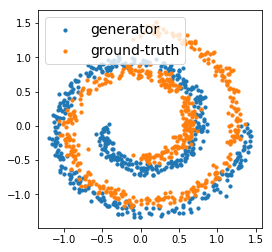

In [ ]:
try:
    d_pos = task.ground_truth_generator()(size)
    d_neg, _ = task.generator(task.example_parameters())(size)
    
    plt.figure(figsize=(4, 4))
    plt.scatter(d_neg[:512, 0], d_neg[:512, 1], label='generator', s=10)
    plt.scatter(d_pos[:512, 0], d_pos[:512, 1], label='ground-truth', s=10)
    plt.legend(loc='upper left', fontsize=14)
    plt.savefig('%s-example.pdf' % (task.name(), ))
except:
    import traceback as tb
    tb.print_exc()

In [ ]:
divergences = {
    name : np.zeros(shape=(params.shape[0], ))
    for name in clfs
}

for i, param in enumerate(tqdm(params)):
    if task.is_synthetic():
        data_neg = task.transform(data_neg_0, [param])
        data_neg_test = task.transform(data_neg_test_0, [param])
    else:
        data_neg = task.generator([param])(size)
        data_neg_test = task.generator([param])(size)
        
    data, labels = combine(data_pos, data_neg)
    data_test, labels_test = combine(data_pos_test, data_neg_test)
    
    for name in clfs:
        clf = clfs[name]
        
        X_pos = torch.tensor(data[labels > 0.5, :], device=device, requires_grad=False, dtype=torch.float32)
        X_neg = torch.tensor(data[labels < 0.5, :], device=device, requires_grad=False, dtype=torch.float32)
        
        clf.fixed_fit(X_pos, X_neg, n_iterations=4 * 1024)
        proba = clf.predict_proba(data_test)
        
        divergences[name][i] = np.log(2) - np.mean(
            logloss(labels_test, proba[:, 1])
        )

In [ ]:
import pickle
with open('pJSD-%s-%s.pickled' % (task.name(), clf_type), 'wb') as f:
    pickle.dump(divergences, f)

In [ ]:
import pickle
with open('pJSD-%s-%s.pickled' % (task.name(), clf_type), 'rb') as f:
    divergences = pickle.load(f)

In [ ]:
plt.figure(figsize=(8, 8))
for i in range(4):
    plt.plot(params, divergences['JSD_%d' % (i + 1, )], '--', color='black')

plt.plot(params, divergences['JSD'], '-', color='black', label='JSD')

plt.plot(params, divergences['JSD-l2'], lw=2, label='linear pJSD', color=plt.cm.tab10(0))
plt.plot(params, divergences['JSD-dropout'], lw=2, label='logarithmic pJSD', color=plt.cm.tab10(1))
    
plt.legend(loc='upper left', fontsize=14, framealpha=0.95)
plt.xlabel(task.parameters_names()[0], fontsize=14)
plt.ylabel('divergence', fontsize=14)

plt.savefig('%s-%s.pdf' % (task.name(), clf_type))